In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
cd /raid/home/myang349/recsys-filterbubbles/

/raid/home/myang349/recsys-filterbubbles


# Imports

In [241]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torch.optim as optim
from os import listdir
from os.path import isfile, join
from tracin.tracin import (
    save_tracin_checkpoint,
    load_tracin_checkpoint,
    calculate_tracin_influence,
)
import pandas as pd
from LSTM_clean.utils import filter_and_split_data, sequence_generator, load_community_dict, get_communities, shannon_index, gini_simpson_index, num_unique
from LSTM_clean.model import LSTM 
from collections import Counter
import numpy as np
import pickle
from collections import defaultdict
import copy
from torch.optim import SGD
from lstm_wrapper import train_model, get_topk_predictions
from dataclasses import dataclass
import matplotlib.pyplot as plt
from copy import deepcopy
import math
import seaborn as sns
sns.set(style='darkgrid')

# Loading Data

In [5]:
# Data Location
# Use SAVE_PREFIX to mark different datasets
SAVE_PREFIX = "104k"
SAVE_FOLDER = "/raid/home/myang349/recsys-filterbubbles/data/twitch_sequence/"
SAVE_TRAIN_NAME = SAVE_PREFIX + "train.data"
SAVE_VALID_NAME = SAVE_PREFIX + "valid.data"
SAVE_TEST_NAME = SAVE_PREFIX + "test.data"
SAVE_COMMUNITY_NAME = SAVE_PREFIX + "lstm_idx_communities.data"

In [6]:
train_data = np.load(os.path.join(SAVE_FOLDER, SAVE_TRAIN_NAME), allow_pickle=True)
valid_data = np.load(os.path.join(SAVE_FOLDER, SAVE_VALID_NAME), allow_pickle=True)
test_data = np.load(os.path.join(SAVE_FOLDER, SAVE_TEST_NAME), allow_pickle=True)

# Loading model

In [9]:
# model = train_model()

# Init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)
model = LSTM(input_size=128, output_size=3312, hidden_dim=64, n_layers=1, device=device) 
model.LSTM.flatten_parameters()
optimizer = optim.SGD(model.parameters(), lr=5e-2, momentum=0.9)

# Loading
model, _, epoch, loss = load_tracin_checkpoint(model, optimizer, "/raid/home/myang349/recsys-filterbubbles/checkpoints/lstm_checkpoint_epoch600.pt")

Device is cuda


In [10]:
model.to(device)

LSTM(
  (item_emb): Embedding(3312, 128, padding_idx=0)
  (LSTM): LSTM(128, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=3312, bias=True)
)

## Verify the recall

In [11]:
# Generate sequences and gt
sequences = [pt[0] for pt in valid_data]
# sequences = [list(reversed(pt[0]))[:10] for pt in valid_data]
gt = [pt[1] for pt in valid_data]

In [12]:
# Generate predictions
predictions = get_topk_predictions(model, sequences, k=50)

In [13]:
assert len(sequences) == len(predictions)
hit = 0
total = 0
for i, val in enumerate(gt):
    if val in predictions[i][:10]:
        hit += 1
    total += 1  
hit/total

0.5059769615301022

## Computing community vectors

In [15]:
community_dict = load_community_dict(os.path.join(SAVE_FOLDER, SAVE_COMMUNITY_NAME))

## Converting prev and predictions to be equal length and in community embedding

In [16]:
LOOKBACK = 50
THRESHOLD = 0

In [17]:
# Alternate version where we just get the last lookback from prev
prev_comm = []
pred_comm = []

for i in range(len(sequences)):
    prev = list(reversed(sequences[i]))[:LOOKBACK]
    n = len([x for x in prev if x != 0 and x in community_dict])
    
    if n < THRESHOLD:
        continue
        
    pred = predictions[i][:n]
    prev_comm.append(get_communities(prev, community_dict))
    pred_comm.append(get_communities(pred, community_dict))
    
for i in range(len(prev_comm)):
    assert len(prev_comm[i]) ==len(pred_comm[i])
    assert THRESHOLD <= len(prev_comm[i]) <= LOOKBACK
    
print(len(sequences))
print(len(prev_comm))

9202
9202


# Computing Buckets for Validation

In [194]:
# GETS COMMUNITIES FOR YOU
def is_filter_bubble(sequence, label):
    communities = get_communities(sequence, community_dict)
    hm_communities = Counter(communities)
    for k, v in hm_communities.items():
        if v >= 0.95 * len(communities) and k == community_dict[label]:
            return 1.0
    return 0.0

# # Checks label is not the majority comm
# def is_breaking_bubble(sequence, label):
#     communities = get_communities(sequence, community_dict)
#     hm_communities = Counter(communities)
#     for k, v in hm_communities.items():
#         if v >= 0.7 * len(communities) and k != community_dict[label]:
#             return 1.0
#     return 0.0

# Checks label is a brand new community
def is_breaking_bubble(sequence, label):
    communities = get_communities(sequence, community_dict)
    hm_communities = Counter(communities)
    for k, v in hm_communities.items():
        if v >= 0.9 * len(communities) and community_dict[label] not in communities:
            return 1.0
    return 0.0

In [164]:
sequences = [pt[0] for pt in valid_data]
gt = [pt[1] for pt in valid_data]

In [165]:
assert len(sequences) == len(gt) == 9202

In [202]:
# Filter bubble
nums = []
filter_bubble_data = []
for i, sequence in enumerate(sequences):
    for j in range(10):
        nums.append(is_filter_bubble(sequence, predictions[i][j]))
        if nums[-1] == 1:
            filter_bubble_data.append([sequence, predictions[i][j]])
with open(os.path.join(SAVE_FOLDER, 'filter_bubble_pred_pts.data'), "wb+") as f:
    pickle.dump(filter_bubble_data, f)

In [199]:
sum(nums)/len(nums)

0.3116605085850902

In [200]:
for i in range(5):
    print(get_communities(filter_bubble_data[i][0] + [filter_bubble_data[i][1]], community_dict))

[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
[6, 8, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


In [203]:
# Breaking bubble
nums = []
# breaking_bubble = []
# breaking_bubble_preds = []
breaking_bubble_data = []
for i, sequence in enumerate(sequences):
    for j in range(10):
        nums.append(is_breaking_bubble(sequence, predictions[i][j]))
        if nums[-1] == 1:
            breaking_bubble_data.append([sequence, predictions[i][j]])
#             breaking_bubble_preds.append(predictions[i][j])
with open(os.path.join(SAVE_FOLDER, 'breaking_bubble_pred_pts.data'), "wb+") as f:
    pickle.dump(breaking_bubble_data, f)

In [204]:
temp = np.load(os.path.join(SAVE_FOLDER, 'breaking_bubble_pred_pts.data'), allow_pickle=True)

In [205]:
temp2 = np.load(os.path.join(SAVE_FOLDER, 'filter_bubble_pred_pts.data'), allow_pickle=True)

In [208]:
len(temp2)

28679

In [191]:
for i in range(5):
    print(get_communities(breaking_bubble_data[i][0] + [breaking_bubble_data[i][1]], community_dict))

[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 6]
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10]
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0]
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0]
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 13]


In [189]:
len(breaking_bubble_data)

2825

In [170]:
sum(nums) / len(nums)

0.030699847859161054

In [171]:
len(breaking_bubble) / len(prev_comm)

0.3069984785916105

In [172]:
sum(nums)

2825.0

In [179]:
# # Saving the values
# breaking_bubble_data = []
# for i, seq_idx in enumerate(breaking_bubble_preds):
#     sequence = sequences[seq_idx]
#     next_item = breaking_bubble_preds[i]
#     breaking_bubble_data.append([sequence, next_item])
#     print(prev_comm[i], next_item)
#     break

[8, 8, 8, 8, 8, 8, 13, 13, 13, 8, 8, 8, 8, 8, 8, 8, 8, 8, 13, 13, 13, 13] 110


# Computing buckets for train

In [250]:
def is_diverse(sequence, label):
    communities = get_communities(sequence, community_dict)
    diversity = gini_simpson_index(communities, community_dict)
    if diversity > 0.5 and community_dict[label] not in communities:
        return 1.0
    return 0.0

In [233]:
sequences = [pt[0] for pt in train_data]
gt = [pt[1] for pt in train_data]

In [230]:
# Filter bubble
nums = []
train_pts_filter_bubble = []
for i, sequence in enumerate(sequences):
    if len(get_communities(sequence, community_dict)) < 30:
        continue
    nums.append(is_filter_bubble(sequence, gt[i]))
    if nums[-1] == 1:
        train_pts_filter_bubble.append([sequence, gt[i]])
with open(os.path.join(SAVE_FOLDER, 'train_pts_filter_bubble.data'), "wb+") as f:
    pickle.dump(filter_bubble_data, f)

In [231]:
len(train_pts_filter_bubble)

5380

In [237]:
# Breaking bubble
nums = []
train_pts_breaking_bubble = []
for i, sequence in enumerate(sequences):
    if len(get_communities(sequence, community_dict)) < 8:
        continue
    nums.append(is_breaking_bubble(sequence, gt[i]))
    if nums[-1] == 1:
        train_pts_breaking_bubble.append([sequence, gt[i]])
#             breaking_bubble_preds.append(predictions[i][j])
with open(os.path.join(SAVE_FOLDER, 'train_pts_breaking_bubble.data'), "wb+") as f:
    pickle.dump(breaking_bubble_data, f)

In [226]:
sum(nums) / len(nums)

0.011215554252643126

In [223]:
len(train_pts_breaking_bubble)

593

In [251]:
# Diverse pts
nums = []
train_pts_diverse = []
for i, sequence in enumerate(sequences):
    if len(get_communities(sequence, community_dict)) < 8:
        continue
    nums.append(is_diverse(sequence, gt[i]))
    if nums[-1] == 1:
        train_pts_diverse.append([sequence, gt[i]])
#             breaking_bubble_preds.append(predictions[i][j])
with open(os.path.join(SAVE_FOLDER, 'train_pts_diverse.data'), "wb+") as f:
    pickle.dump(train_pts_diverse, f)

In [294]:
set(len(x[1]) for x in train_pts_diverse)

TypeError: object of type 'int' has no len()

In [252]:
len(train_pts_diverse)

212

In [253]:
for i in range(5):
    print(get_communities(train_pts_diverse[i][0] + [train_pts_diverse[i][1]], community_dict))

[13, 13, 13, 2, 14, 7, 13, 2, 2, 7, 13, 13, 6]
[13, 13, 13, 2, 14, 7, 13, 2, 2, 7, 13, 13, 6, 6, 13, 4]
[13, 13, 13, 2, 14, 7, 13, 2, 2, 7, 13, 13, 6, 6, 13, 4, 13, 13, 2, 2, 13, 13, 13, 13, 2, 13, 2, 2, 11]
[13, 13, 13, 2, 14, 7, 13, 2, 2, 7, 13, 13, 6, 6, 13, 4, 13, 13, 2, 2, 13, 13, 13, 13, 2, 13, 2, 2, 11, 2, 2, 2, 7, 3]
[7, 13, 13, 13, 7, 7, 2, 13, 13, 2, 7, 13, 1]


In [ ]:
train_pts_diverse[i][0]

# Analysis

In [23]:
prev_num_comm = 0
pred_num_comm = 0
n = len(prev_comm)
threshold = 0

for i in range(n):
    if len(prev_comm[i]) < threshold:
        assert False
    for j in range(len(prev_comm)):
        prev_num_comm += len(set(prev_comm[i][-j:]))
        pred_num_comm += len(set(pred_comm[i][:j]))

In [27]:
prev_num_comm / (n*(n+1)/2)

4.911088238120476

In [26]:
pred_num_comm / (n*(n+1)/2)

0.0255739773581954

## Distributions

In [99]:
watch_history_length_counts = Counter(len(x) for x in prev_comm)
counts = {k: watch_history_length_counts[k] for k in sorted(watch_history_length_counts)}
assert sum(counts.values()) == n

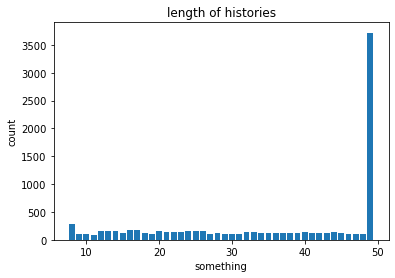

In [155]:
plot_counts(counts, 'length of histories')

In [132]:
prev_unique_comms_by_length = defaultdict(list)
pred_unique_comms_by_length = defaultdict(list)

In [133]:
# Making sure distribution is the same
assert Counter(len(x) for x in pred_comm) == Counter(len(x) for x in prev_comm)

### This experiment is doomed

In [137]:
# for i in range(len(prev_comm)):
#     c1, c2 = prev_comm[i], pred_comm[i]
#     nc1 = len(prev_comm[i])
    
#     prev_unique_comms_by_length[nc1].append(len(set(c1)))
#     pred_unique_comms_by_length[nc1].append(len(set(c2)))

    
# # Convert to floats
# def to_float(hm):
#     hm = deepcopy(hm)
#     for k, v in hm.items():
#         hm[k] = sum(v) / len(v)
#     return hm
    
        
# hm1 = to_float(prev_unique_comms_by_length)
# hm2 = to_float(pred_unique_comms_by_length)

### Plotting the percentage of points that are less diverse, by length

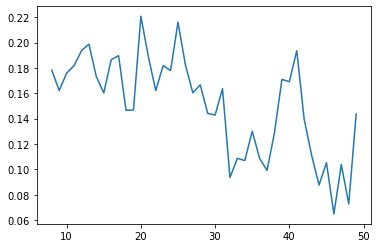

In [184]:
# line plot
fig = plt.figure()
ax = plt.axes()
ax.plot(sorted(hm.keys()), [hm[x] for x in sorted(hm.keys())])

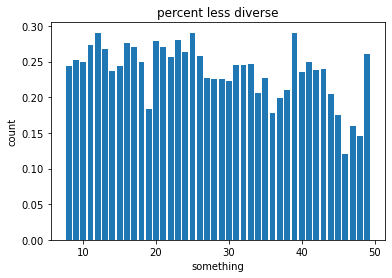

In [271]:
hm = defaultdict(int)
tot = defaultdict(int)
for i in range(len(prev_comm)):
    c1, c2 = prev_comm[i], pred_comm[i]
#     if len(set(c2)) < len(set(c1)):
    if shannon_index(c2, community_dict) < shannon_index(c1, community_dict):
        hm[len(c1)] += 1
    tot[len(c1)] += 1
    
for k in hm:
    hm[k] = hm[k] / tot[k]
plot_counts(hm, 'percent less diverse')

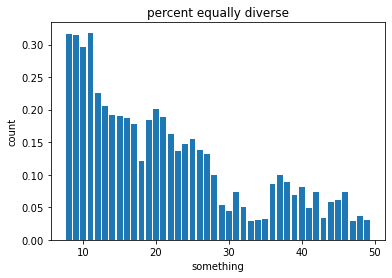

In [273]:
hm = defaultdict(int)
tot = defaultdict(int)
for i in range(len(prev_comm)):
    c1, c2 = prev_comm[i], pred_comm[i]
#     if len(set(c1)) == len(set(c2)):
    if shannon_index(c2, community_dict) == shannon_index(c1, community_dict):
        hm[len(c1)] += 1
    tot[len(c1)] += 1
    
for k in hm:
    hm[k] = hm[k] / tot[k]
plot_counts(hm, 'percent equally diverse')

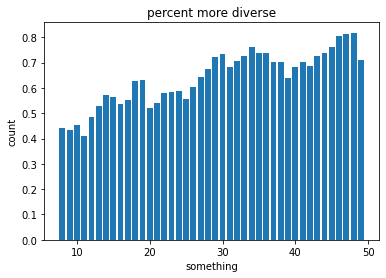

In [274]:
hm = defaultdict(int)
tot = defaultdict(int)
for i in range(len(prev_comm)):
    c1, c2 = prev_comm[i], pred_comm[i]
#     if len(set(c2)) > len(set(c1)):
    if shannon_index(c2, community_dict) > shannon_index(c1, community_dict):
        hm[len(c1)] += 1
    tot[len(c1)] += 1
    
for k in hm:
    hm[k] = hm[k] / tot[k]
plot_counts(hm, 'percent more diverse')

## Raw Diversity

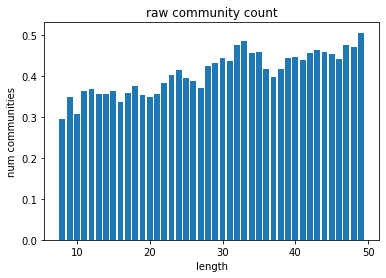

In [275]:
# prev_communities only
hm1 = defaultdict(list)
for i in range(len(prev_comm)):
    c1, c2 = prev_comm[i], pred_comm[i]
    hm1[len(c1)].append(len(set(c1)))

    
# Convert to percents
for k in hm1:
    hm1[k] = np.mean(hm1[k])
plot_counts(hm1, 'raw community count', xlabel='length', ylabel='num communities')

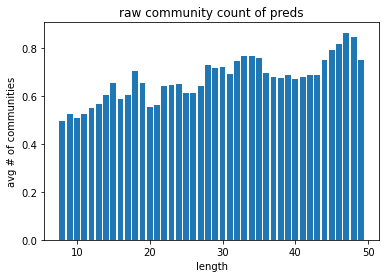

In [276]:
# pred_communities only
hm1 = defaultdict(list)
for i in range(len(pred_comm)):
    c1, c2 = prev_comm[i], pred_comm[i]
    hm1[len(c2)].append(len(set(c2)))
    
# Convert to percents
for k in hm1:
    hm1[k] = np.mean(hm1[k])
plot_counts(hm1, 'raw community count of preds', xlabel='length', ylabel='avg # of communities')

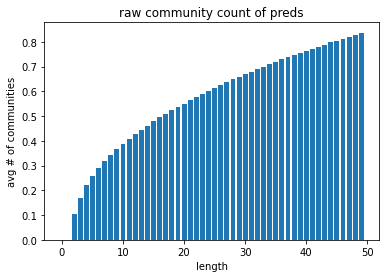

In [279]:
# full pred communities
hm = defaultdict(list)
for pred in predictions:
    c2 = get_communities(pred, community_dict)
    for i in range(len(c2)):
        hm[i].append(len(set(c2[:i])))
for k in hm:
    hm[k] = np.mean(hm[k])
plot_counts(hm, 'raw community count of preds', xlabel='length', ylabel='avg # of communities')

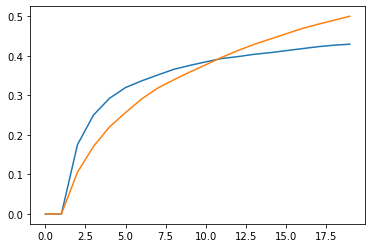

In [284]:
# last k for every train, topk for pred
hm_prev = defaultdict(list)
hm_pred = defaultdict(list)
for i in range(len(prev_comm)):
    c1 = prev_comm[i]
    c2 = get_communities(predictions[i], community_dict)
    for j in range(min(len(c1), 20)):
#         hm_prev[j].append(len(set(c1[:j])))
#         hm_pred[j].append(len(set(c2[:j])))
        hm_prev[j].append(shannon_index(list(reversed(c1))[:j], community_dict))
        hm_pred[j].append(shannon_index(c2[:j], community_dict))
        
for k in hm_prev:
    hm_prev[k] = np.mean(hm_prev[k])
for k in hm_pred:
    hm_pred[k] = np.mean(hm_pred[k])

fig = plt.figure()
ax = plt.axes()
ax.plot(sorted(hm_prev.keys()), [hm_prev[x] for x in sorted(hm_prev.keys())])
ax.plot(sorted(hm_pred.keys()), [hm_pred[x] for x in sorted(hm_pred.keys())])

## Quantifying Diversity Based on Watch History vs Recommendation

In [123]:
def f(c):
    return len(set(c))
    
def f(c):
    hm = Counter(c)
    for val in hm.values():
        if val >= 0.8 * len(c):
            return 1
    return 0

In [124]:
prev_comm_stats = []
pred_comm_stats = []
n = len(prev_comm)
threshold = 0

for i in range(n):
    c1, c2 = prev_comm[i], pred_comm[i]
    if len(c1) < threshold:
        continue
    prev_comm_stats.append(f(c1))
    pred_comm_stats.append(f(c2))

In [125]:
sum(prev_comm_stats)

6063

In [122]:
sum(pred_comm_stats)

8809

# Quantifying Filter-Bubble Based on Combination of Watch History + Recommendation

## Quantify Functions

In [126]:
# Does one of the top 3 predictions belong in a community in the previous history?
def f(prev, pred, threshold=3):
    for comm in pred[:threshold]:
        if comm in prev:
            return 1
    return 0

# Does one of the top-threshold belong in the majority community in the previous history?
def f(prev, pred, threshold=3):
    hm = Counter(prev)
    most_common = max(hm.keys(), key=hm.get)
    
    for comm in pred[:threshold]:
        if comm == most_common:
            return 1
    return 0

# What % of the top-threshold belongs in the most common community in the previous history
def f(prev, pred, threshold=10):
    hm = Counter(prev)
    most_common = max(hm.keys(), key=hm.get)
    
    count = 0
    for comm in pred[:threshold]:
        if comm == most_common:
            count += 1
    return count / threshold

In [127]:
# What percentage of the top-threshold predictions belong in a community in the previous history?
def f(prev, pred, threshold=5):
    count = 0
    for comm in pred[:threshold]:
        if comm in prev:
            count += 1
    return count / threshold

# What percentage of the top-threshold predictions belong in the communities of the last threshold-items in the history?
def f(prev, pred, threshold=10):
    count = 0
    for comm in pred[:threshold]:
        if comm in list(reversed(prev))[:threshold]:
            count += 1
    return count / threshold

## Filter functions

In [128]:
def filter(c):
    hm = Counter(c)
    for val in hm.values():
        if val >= 0.9 * len(c):
            return True
    return False

## This cell actually computes values

In [129]:
counts = []
n = len(prev_comm)
threshold = 0

for i in range(n):
    c1, c2 = prev_comm[i], pred_comm[i]
#     if not filter(c1):
#         continue
    if len(c1) < threshold:
        continue
    counts.append(f(c1,c2))

In [130]:
sum(counts)/len(counts)

0.9331102540834695

In [131]:
sum(counts)/len(counts)

0.9331102540834695

In [ ]:
1 -> 1
12 -> 2
122 -> 3
1223 -> 4

In [ ]:
valid_data

## Extracting filter bubble pts + breaking the filter bubble pts

In [237]:
DIVERSITY_FOLDER = os.path.join(SAVE_FOLDER, "twitch_sequence")

In [254]:
pwd

'/raid/home/myang349/recsys-filterbubbles'

In [256]:
curr = '/raid/home/myang349/recsys-filterbubbles/myang_code_refactor/final_analysis'

In [283]:
with open(os.path.join(curr, "train_filter_test_breaking.pkl"), "rb") as f:
    influences = pickle.load(f)

In [284]:
np.mean(influences)

-0.0044886920863064

In [285]:
np.median(influences)

0.0006271496531553566

In [287]:
with open(os.path.join(curr, "train_filter_test_filter.pkl"), "rb") as f:
    influences = pickle.load(f)

In [288]:
np.mean(influences)

-1.3877570306882263

In [289]:
np.median(influences)

-0.10749754309654236

In [290]:
with open(os.path.join(curr, "train_breaking_test_breaking.pkl"), "rb") as f:
    influences = pickle.load(f)

In [291]:
np.mean(influences)

0.9141899358481169

In [292]:
np.median(influences)

0.42274895310401917